# Salary predictin

## Data develop

> [**Pre-processing**](#1)

> [**Feature engineer**](#2)

> [**Model tuning**](#3)

> [**Model evaluation**](#4)
>> [**Examine features importances**](#5)

> [**Conclusion**](#6)

### Import modules and data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

#your info here
__author__ = "Ya Yu Chen"
__email__ = "a725761@gmail.com"

In [2]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [3]:
train_features = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\notebooks\\data examine\\cleaned_shuffle_train_df.csv'
test_features = 'C:\\Users\\EllenChen\\Desktop\\DSDJ\\case study\\HR and salary prediction example\\salaryprediction\\data\\train_features.csv'

train_df = load_data(train_features)
test_feature_df = load_data(test_features)

In [4]:
cat_feature = [i for i in train_df.columns if train_df[i].dtype.name == 'object' or train_df[i].dtype.name == 'category']
num_feature = [i for i in train_df.columns if train_df[i].dtype.name == 'int64'  or train_df[i].dtype.name == 'float']

 <a id="1"></a>
## Pre-processing

### Label encoding train and test features

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [8]:
# train df 
encoded_df = train_df.iloc[:, 3:].copy()
#test df
test_ec_df = test_feature_df.iloc[:, 2:].copy()

In [9]:
# feature label encoding
def Label_encoder(df, col):
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

# label encoding train df
for i in encoded_df.columns:
    Label_encoder(encoded_df, i)
# label encoding test df
for i in test_ec_df.columns:
    Label_encoder(test_ec_df, i)

In [10]:
encoded_df.columns

Index(['jobType', 'degree', 'major', 'industry', 'yearsExperience',
       'milesFromMetropolis', 'salary'],
      dtype='object')

In [13]:
cat_feature[2:]

['jobType', 'degree', 'major', 'industry']

 <a id="2"></a>
## Features engineer

* Group by train data's categorical features
* Create new features by computing target's statistical data
* Combine new features with origin data

In [14]:
def group_feature(df, col):
    return df.groupby(by=col)

groups = group_feature(encoded_df, cat_feature[2:])

In [15]:
# train equal train features col
def groups_central_stat(groups, target):
    groups_df = pd.DataFrame({'groups_mean': groups[target].mean()})
    groups_df['groups_max'] = groups[target].max()
    groups_df['groups_min'] = groups[target].min()
    groups_df['groups_std'] = groups[target].std()
    groups_df['groups_median'] = groups[target].median()
    groups_df.reset_index(inplace=True)
    return groups_df

groups_df = groups_central_stat(groups, 'salary')

In [16]:
def groups_bin_stat(groups, target):
    groups_bin = pd.DataFrame({'groups_0%': groups[target].quantile(0.0)})
    groups_bin['groups_25%'] = groups[target].quantile(0.25)
    groups_bin['groups_50%'] = groups[target].quantile(0.50)
    groups_bin['groups_75%'] = groups[target].quantile(0.75)
    groups_bin['groups_100%'] = groups[target].quantile(1.0)
    groups_bin.reset_index(inplace=True)
    return groups_bin

groups_bin = groups_bin_stat(groups, 'salary')

In [17]:
# keys = col feature name
def merge_df(df1, df2, keys, fillna=False):
    df1 = pd.merge(df1, df2, on=keys, how='left')
    if fillna:
        df1.fillna(0, inplace=True)
    return df1

In [18]:
new_features = [groups_df, groups_bin]

for i in new_features:
    encoded_df = merge_df(encoded_df, i, cat_feature[2:], fillna=True)
    test_ec_df = merge_df(test_ec_df, i, cat_feature[2:], fillna=True)
    
print(encoded_df.shape)
print(test_ec_df.shape)

(999995, 17)
(1000000, 16)


 <a id="3"></a>
## Model tuning

* Using RandomixedSearchCV first and look for best range of hyperparameters for models
* Using GridSearchCV after and look for the best hyperparemeters for models

In [ ]:
# tuning model parameters to get a better model
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(0,100,num=20)]
max_features = [float(x/(X_encoded.shape[0])) for x in np.linspace(0,80, num=20)]
max_depth = [int(x) for x in np.linspace(0,80, num=20)]
max_depth.append(None)
max_depth_gbr = [int(x) for x in np.linspace(0,25, num=20)]
max_depth_gbr.append(None)
min_samples_split = [int(x) for x in np.linspace(0,100,num=20)]
random_grid = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_split':min_samples_split}
random_grid_gbr = {'n_estimators':n_estimators, 'max_depth':max_depth_gbr}

# check parameters
print(random_grid_gbr)

In [ ]:
# fitting models to get the best params
rf_ec = RandomForestRegressor()
gbr_ec = GradientBoostingRegressor()
rsCV_ec = RandomizedSearchCV(gbr_ec, param_distributions = random_grid_gbr, pre_dispatch=4, cv=2, verbose=1, random_state=1, n_jobs=4)
rsCV_ec.fit(X_encoded, y_encoded)
print(rsCV_ec.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [55, 60], 
             'max_features': [10, 11],
             'max_depth': [10, 20],
             'min_samples_split': [38, 40]}

param_grid_gbr = {'n_estimators': [80, 90], 
             'max_depth': [4, 5]}

In [ ]:
rf_gid = RandomForestRegressor()
gbr_gid = GradientBoostingRegressor()
grid = GridSearchCV(gbr_gid, param_grid= param_grid_gbr, cv=3, verbose=2, n_jobs=4)
grid.fit(X_encoded, y_encoded)
print('The best hyperparameters are: ', grid.best_params_)

 <a id="4"></a>
## Model evaluation

### Using cross validation evaluate models performance by MSE

In [19]:
# using label encoding for Random Forest Regressor and Gradient Boosting Regressor modeling
# using cross validation score to determine which model perform the best

def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=3, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

# print out summary and compare results
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

models = []
mean_mse = {}
cv_std= {}
num_procs = 4
verbose_level = 0

reg = LinearRegression()
reg_poly = make_pipeline(PolynomialFeatures(), LinearRegression())
reg_scaled = make_pipeline(StandardScaler(), LinearRegression())
rf = RandomForestRegressor(n_estimators=55, n_jobs=num_procs, max_depth=10, min_samples_split=38,max_features=11, verbose=verbose_level,
                          random_state=1)
gbr = GradientBoostingRegressor(n_estimators=90, max_depth=5, loss='ls', verbose=verbose_level,
                               random_state=1)

models.extend([reg, reg_poly, reg_scaled, rf, gbr])

In [21]:
# using label encoder feature for input 

# label encoding train df
X_encoded = encoded_df.drop(['salary'], axis=1)
y_encoded = encoded_df['salary']

In [22]:
# testing model performance
for i in models:
    train_model(i, X_encoded, y_encoded, num_procs, mean_mse, cv_std)
    print_summary(i, mean_mse, cv_std)


Model:
 LinearRegression()
Average MSE:
 370.95993513425964
Standard deviation during CV:
 0.5891755997113964

Model:
 Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])
Average MSE:
 353.4224992200339
Standard deviation during CV:
 0.43102956729434705

Model:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])
Average MSE:
 370.95993513425964
Standard deviation during CV:
 0.5891755997113329

Model:
 RandomForestRegressor(max_depth=10, max_features=11, min_samples_split=38,
                      n_estimators=55, n_jobs=4, random_state=1)
Average MSE:
 357.2796779202791
Standard deviation during CV:
 0.39630811171762353

Model:
 GradientBoostingRegressor(max_depth=5, n_estimators=90, random_state=1)
Average MSE:
 354.90642180401755
Standard deviation during CV:
 0.392642078460288


### Select the best model

In [23]:
# choice the best model
def best_model(mean_mse):
    return min(mean_mse, key=mean_mse.get)

best_model = best_model(mean_mse)
print(best_model)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])


 <a id="5"></a>
### Examine feature importances

In [24]:
# use gbr model to check every train feature's importances
def create_feature_importance(model, train_df):
    importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'features': train_df.columns, 'importances': importances})
    feature_importances_df.sort_values(by='importances', ascending = False, inplace=True)
    feature_importances_df.set_index('features', inplace=True, drop=True)
    return feature_importances_df

model_gbr = gbr
gbr.fit(X_encoded, y_encoded)
feature_importance = create_feature_importance(gbr, X_encoded)

                     importances
features                        
groups_mean             0.620891
yearsExperience         0.185851
milesFromMetropolis     0.128117
groups_25%              0.036448
groups_50%              0.010584
groups_75%              0.006846
groups_median           0.006804
groups_0%               0.001628
groups_min              0.001445
groups_std              0.001205
groups_100%             0.000072
groups_max              0.000070
major                   0.000014
jobType                 0.000013
industry                0.000007
degree                  0.000006


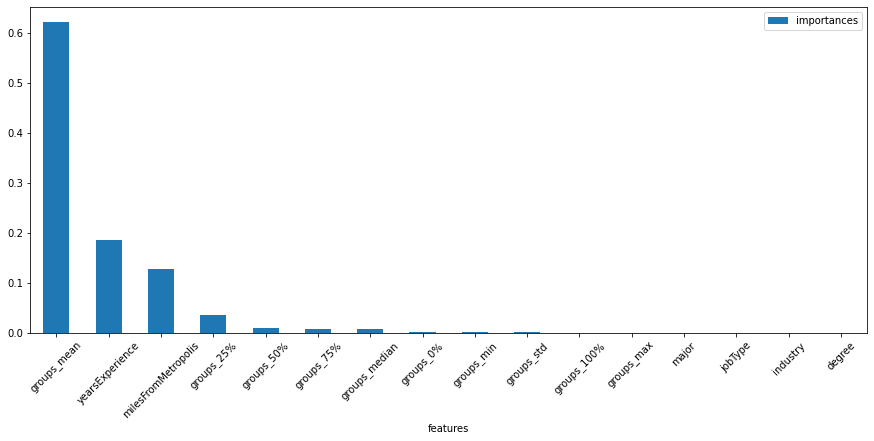

In [28]:
def plot_feature_importance(fm_df):
    fm_df.plot.bar(figsize=(15,6))
    plt.xticks(rotation=45)
    plt.show()
    
plot_feature_importance(feature_importance)

 <a id="6"></a>
## Conclusion

> **Job types:**
>> 1. The strongest correlation is **job type**, the job type which salary mean below 100 is **25%** of all individuals, only a job role as **junior** or **janitor**.
>> 2. Compare the highest and lowest salary avg  in job type. (**70** vs **145**)
>> 3. The top 3 high salary industry is **oil, financa and web**, the average salary is over **120**, even the job role as a junior in these 3 industry, the lowest income still **higher** than other industries at same level.
>
> **Degrees:**
>> The lowest salary with the degree level at **None** or **high school** is around **100**.
>
>**Major:**
>> Any individual with major, the salary is **1.3** times higher than without it.
>
>**Years of experience**
>> Years of experience is 12 years, the average salary of less than 12 yrs is around **100**, if over is around **130**, the average is **1.3** times more.
>
>**Miles from metropolis:**
>> Average distance is 49.5 miles, the average salary below it is **126**, if over is **106**, the average is **1.2** times less if workplace distance over average miles.
>
>**Grouping categorical features:**
>> 1. New feature **group mean** become the most important feature for train dataset.
>>> Job types **BELOW** group mean: **60%**(other roles) vs **40%**(Junior & Janitor).                                     
>>> Job types **ABOVE** group mean: **93%**(other roles) vs **7%**(Junior & Janitor).
>> 2. Compare origin features, only **years of experience** and **milesFromMetropolis** have higher importance scores.